In [1]:
import numpy as np
import timm.optim
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
import timm
import timm.optim as tioptim
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import json

from tqdm import tqdm
from torch.utils.data import DataLoader,random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv('./data/train-metadata.csv')
test_df = pd.read_csv('./data/test-metadata.csv')

/tmp/ipykernel_98824/2102509107.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('./data/train-metadata.csv')


In [3]:
train_df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [4]:
train_df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

In [5]:
train_df['target'].value_counts()

0    400666
1       393
Name: target, dtype: int64

In [6]:
test_df

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,31.114600,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,68.141071,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,41.358640,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [7]:
test_df.columns

Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

In [8]:
set(train_df.columns) - set(test_df.columns)

{'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'iddx_full',
 'lesion_id',
 'mel_mitotic_index',
 'mel_thick_mm',
 'target',
 'tbp_lv_dnn_lesion_confidence'}

<Axes: ylabel='Frequency'>

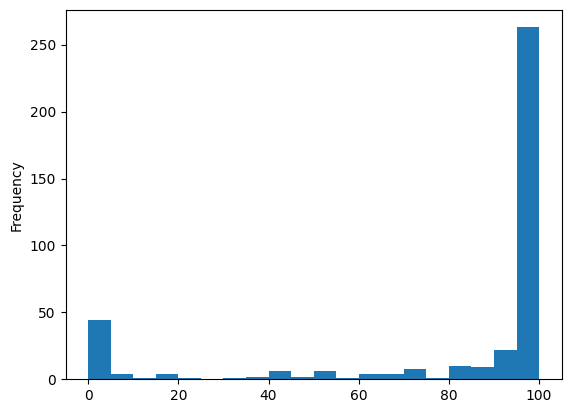

In [9]:
train_df[train_df['target'] == 1]['tbp_lv_dnn_lesion_confidence'].plot.hist(bins=20)

In [10]:
rf_train_df = train_df.drop(columns=['iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'iddx_full',
 'lesion_id',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence','copyright_license','attribution','isic_id','patient_id'])
rf_train_df

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,...,0.000000,9.307003,0.000000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,0,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,...,0.000000,3.354148,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,0,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,...,0.000000,8.886309,0.000000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,0,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,...,1.771705,9.514499,0.664690,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,0,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,...,0.000000,6.467562,0.000000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,0,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,14.944666,27.663259,...,7.348126,20.210836,2.328066,7.054819,2.169398,0.288920,100,147.187256,1182.317505,122.652588
401055,0,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,16.026870,34.158840,...,2.795246,9.340242,1.048147,1.879502,2.910780,0.460000,25,52.349740,1393.187000,127.261700
401056,0,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,12.364397,29.845326,...,1.660411,5.999862,0.607554,1.702824,2.205272,0.183099,40,54.622246,1065.263672,-106.833740
401057,0,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,9.564721,28.431200,...,3.583966,9.113276,1.078204,3.680175,1.957157,0.161850,140,-9.861557,877.527000,-76.982120


In [11]:
rf_train_df.dropna(inplace=True)

In [12]:
number_features = []
category_features = []
for col in rf_train_df.columns:
    if col == 'target':
        continue
    if rf_train_df[col].dtype == 'int64' or rf_train_df[col].dtype == 'float64':
        number_features.append(col)
    else:
        category_features.append(col)

number_features, category_features

(['age_approx',
  'clin_size_long_diam_mm',
  'tbp_lv_A',
  'tbp_lv_Aext',
  'tbp_lv_B',
  'tbp_lv_Bext',
  'tbp_lv_C',
  'tbp_lv_Cext',
  'tbp_lv_H',
  'tbp_lv_Hext',
  'tbp_lv_L',
  'tbp_lv_Lext',
  'tbp_lv_areaMM2',
  'tbp_lv_area_perim_ratio',
  'tbp_lv_color_std_mean',
  'tbp_lv_deltaA',
  'tbp_lv_deltaB',
  'tbp_lv_deltaL',
  'tbp_lv_deltaLB',
  'tbp_lv_deltaLBnorm',
  'tbp_lv_eccentricity',
  'tbp_lv_minorAxisMM',
  'tbp_lv_nevi_confidence',
  'tbp_lv_norm_border',
  'tbp_lv_norm_color',
  'tbp_lv_perimeterMM',
  'tbp_lv_radial_color_std_max',
  'tbp_lv_stdL',
  'tbp_lv_stdLExt',
  'tbp_lv_symm_2axis',
  'tbp_lv_symm_2axis_angle',
  'tbp_lv_x',
  'tbp_lv_y',
  'tbp_lv_z'],
 ['sex',
  'anatom_site_general',
  'image_type',
  'tbp_tile_type',
  'tbp_lv_location',
  'tbp_lv_location_simple'])

In [13]:
rf_train_df.isna().sum()

target                         0
age_approx                     0
sex                            0
anatom_site_general            0
clin_size_long_diam_mm         0
image_type                     0
tbp_tile_type                  0
tbp_lv_A                       0
tbp_lv_Aext                    0
tbp_lv_B                       0
tbp_lv_Bext                    0
tbp_lv_C                       0
tbp_lv_Cext                    0
tbp_lv_H                       0
tbp_lv_Hext                    0
tbp_lv_L                       0
tbp_lv_Lext                    0
tbp_lv_areaMM2                 0
tbp_lv_area_perim_ratio        0
tbp_lv_color_std_mean          0
tbp_lv_deltaA                  0
tbp_lv_deltaB                  0
tbp_lv_deltaL                  0
tbp_lv_deltaLB                 0
tbp_lv_deltaLBnorm             0
tbp_lv_eccentricity            0
tbp_lv_location                0
tbp_lv_location_simple         0
tbp_lv_minorAxisMM             0
tbp_lv_nevi_confidence         0
tbp_lv_nor

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import RocCurveDisplay,roc_auc_score,roc_curve

In [15]:
# process the data
pipe = ColumnTransformer([
    ('scaler',StandardScaler(),number_features),
    ('encoder',OneHotEncoder(),category_features)
])

X = rf_train_df.drop(columns=['target'])
y = rf_train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# train the model
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
roc_auc

0.5

In [16]:
rf_test_df = test_df.drop(columns=['copyright_license','attribution','isic_id','patient_id'])
rf_test_df

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,28.38412,27.043640,...,1.143374,9.387248,0.304827,1.281532,31.114600,0.479339,20,-155.06510,1511.222000,113.980100
1,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,31.31752,27.524318,...,0.000000,6.340311,0.000000,1.271940,68.141071,0.426230,25,-112.36924,629.535889,-15.019287
2,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,30.46368,28.384240,...,0.721739,8.130868,0.230742,1.080308,41.358640,0.366071,110,-84.29282,1303.978000,-28.576050


In [17]:
rf_test_df = pipe.transform(rf_test_df)

y_pred = clf.predict_proba(rf_test_df)[:,1]

y_pred

array([0.06, 0.04, 0.02])

In [18]:
sumbit_template = pd.read_csv('./data/sample_submission.csv')
sumbit_template

,isic_id,target
0,ISIC_0015657,0.3
1,ISIC_0015729,0.3
2,ISIC_0015740,0.3


In [19]:
sumbit_template['target'] = y_pred
sumbit_template

,isic_id,target
0,ISIC_0015657,0.06
1,ISIC_0015729,0.04
2,ISIC_0015740,0.02


In [20]:
sumbit_template.to_csv('./data/submission.csv',index=False)